In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import random

mat = sio.loadmat('H_matrix/Hmatrix.mat') # Load Parity Check Matrix From Matlab File
H = mat['H'] # Parity Check Matrix

In [2]:
def BSC(encodedM, probability):
    noisy = np.zeros(len(encodedM),dtype=int) #  noisy Message
    count = 0
    for i in encodedM:
        if random.random() <= probability:
            if i==0:
                noisy[count] = 1
            else:
                noisy[count] = 0
        else:
            noisy[count] = i
        count += 1
    return noisy

In [3]:
dv = sum(np.transpose(H)[0]) # Degree of each VN
dc = sum(H[0]) # Degree of each CN
n = len(H[0]) # Length of Message
u = len(H) # Nos of Parity bits

CNs = np.zeros((u, 2 * dc), dtype=int) # for each CN - [connected VNs' index , that VNs' message]
VNs = np.zeros((n, (2 * dv) + 1), dtype=int) # for each VN - [decoded Message bit , connected CNs' index , that CNs' message]

# index storing for VNs
for i in range(n):
    index = 0
    for j in range(u):
        if H[j][i] == 1:
            VNs[i][1 + index] = j
            index += 1

# index storing for CNs
for i in range(u):
    index = 0
    for j in range(n):
        if H[i][j] == 1:
            CNs[i][index] = j
            index += 1

In [4]:
c = np.zeros(n,dtype=int) # Transmitted Message in BSC

p = np.arange(0,1.1,0.1) # BSC error Probabilities from 0 to 1 in  0.1 step increase
s = np.zeros(len(p)) # to store success probabilities
f = 0

# For each probability in p
for pError in p:
    success = 0 # count success in Monte-Karlo simulation

    # Monte-Karlo simulation
    for Nsim in range(1000):
        
        ReceivedMessage = BSC(c,pError) # Received Noisy Message from BSC

        for i in range(n):
            VNs[i][0]=ReceivedMessage[i]

        # VN to CN for 0th iteration
        for i in range(u):
            for j in range(dc,2*dc):
                CNs[i][j] = VNs[CNs[i][j-dc]][0]
        
        # Loop Process
        for cycle in range(100):

            codeword = np.zeros(n,dtype=int) # For storing Previous iteration's Decoded Message
            for i in range(n):
                codeword[i] = VNs[i][0]

            # Check for all CNs if they satisfy even parity or not
            # if yes then terminate loop process
            count = 0
            for c_n in range(u):
                if sum(CNs[c_n][dc:2*dc])%2 == 0 :
                    count+=1
                else:
                    break
            if count==u: # if yes then terminate loop process
                break

            # CN to VN message passing (Sum modulo 2 process)
            for c_n in range(u):
                sumOfAll_CNs = sum(CNs[c_n][dc:2*dc])
                for idx in range(dc):
                    for x in range(1,1+dv):
                        if VNs[CNs[c_n][idx]][x] == c_n:
                            VNs[CNs[c_n][idx]][x+dv] = (sumOfAll_CNs-CNs[c_n][dc+idx])%2
                            break

            # Doing majority voting for each VN
            for i in range(n):
                ones = sum(VNs[i][1+dv:2*dv+1]) + ReceivedMessage[i]
                zeros = dv+1-ones
                if ones>zeros:
                    VNs[i][0]=1
                elif zeros>ones:
                    VNs[i][0]=0

            # VN to CN message passing (Majority vote process)
            for i in range(u):
                for c_n in range(dc, 2 * dc):
                    ones = ReceivedMessage[CNs[i][c_n - dc]] + sum(VNs[CNs[i][c_n - dc]][1+dv:(2*dv)+1])
                    zeros = dv + 1 - ones
                    for v_n in range(1, dv + 1):
                        if VNs[CNs[i][c_n - dc]][v_n] == i:
                            temp_ones = ones
                            temp_zeros = zeros
                            if VNs[CNs[i][c_n - dc]][v_n+dv]==1: 
                                temp_ones -= 1
                            else: 
                                temp_zeros -= 1
                            if temp_ones > temp_zeros: 
                                CNs[i][c_n]=1
                            elif temp_zeros > temp_ones: 
                                CNs[i][c_n]=0
                            break
            
            # check if previous iteration's decoded message and present iteration's decoded message is same or not
            # if yes then terminate loop process
            check = True
            for i in range(n):
                if codeword[i] != VNs[i][0]:
                    check = False
                    break
            if check: # if yes then terminate loop process
                break

        # check for if we got real transmitted message or not
        message_check = True
        for i in range(n):
            if VNs[i][0] != c[i]:
                message_check = False
                break
        if message_check:
            success+=1
    
    s[f]=(success/1000)
    f += 1

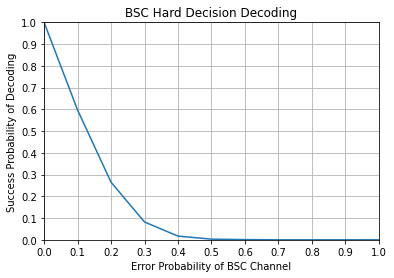

In [5]:
plt.plot(p, s)
plt.xlabel('Error Probability of BSC Channel')
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(0,1.1,0.1))
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Success Probability of Decoding')
plt.title('BSC Hard Decision Decoding')
plt.grid()
plt.show()